# Charactor-level RNN for wiki

    modified from https://pytorch.org/tutorials/intermediate/char_rnn_generation_tutorial.html

In [1]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

import time
import math

import torch
import torch.nn as nn

# # Plus EOS marker
# keywords_dict = {}
# keywords_dict['all_letters'] = string.ascii_letters + " .,;'-"
# keywords_dict['n_letters'] = len(keywords_dict['all_letters']) + 1

# def findFiles(path): return glob.glob(path)

# # Turn a Unicode string to plain ASCII, thanks to https://stackoverflow.com/a/518232/2809427
# def unicodeToAscii(s, keywords_dict):
#     return ''.join(
#         c for c in unicodedata.normalize('NFD', s)
#         if unicodedata.category(c) != 'Mn'
#         and c in keywords_dict['all_letters']
#     )

# # Read a file and split into lines
# def readLines(filename, keywords_dict):
#     lines = open(filename, encoding='utf-8').read().strip().split('\n')
#     return [unicodeToAscii(line, keywords_dict) for line in lines]

# # Build the category_lines dictionary, a list of lines per category
# name_list = []
# for filename in findFiles('data/names/*.txt'):
#     category = os.path.splitext(os.path.basename(filename))[0]
#     name_list.extend(readLines(filename, keywords_dict))
    
# keywords_dict['name_vector'] = name_list

In [110]:
# parameter
keywords_dict ={}
keywords_dict['hidden_size'] = 100
keywords_dict['seq_length'] = 25
keywords_dict['learning_rate'] = 0.1


In [112]:
data = open('data/shakespeare_input.txt', 'r',encoding='utf-8').read() # should be simple plain text file
chars = list(set(data))
data = data[:1000000]
data_size, vocab_size = len(data), len(chars)
print('data has %d characters, %d unique.' % (data_size, vocab_size))
keywords_dict['data_size'] = len(data)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

data has 1000000 characters, 67 unique.


In [114]:
keywords_dict['all_letters'] = ''.join(sorted(chars))
keywords_dict['n_letters'] = len(chars)


In [18]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.Wxh = nn.Linear(input_size, hidden_size)
        self.Whh = nn.Linear(hidden_size, hidden_size)
        self.Why = nn.Linear(hidden_size, output_size)
        self.act = nn.Tanh()
        self.dropout = nn.Dropout(0.1)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, _input, hidden):
        # np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t-1]) + bh)
        hidden = self.Wxh(_input).add(self.Whh(hidden))
        hidden = self.act(hidden)
        
        output = self.Why(hidden)
        
        # output
        output = self.dropout(output)
        output = self.softmax(output)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, self.hidden_size)

In [66]:
import random

# Random item from a list
# def randomChoice(l):
#     _a = l[random.randint(0, len(l) - 1)]
#     print(_a)
#     return _a

In [5]:
# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
#         print(letter)
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line, keywords_dict):
    all_letters = keywords_dict['all_letters']
    n_letters = keywords_dict['n_letters']
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

def createTrainingExample(line, keywords_dict):
#     category, line = randomTrainingPair()
#     line = randomChoice(keywords_dict['name_vector'])
#     category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line[:-1], keywords_dict)
#     print(input_line_tensor)
    target_line_tensor = targetTensor(line[1:], keywords_dict)
#     print(target_line_tensor)

#     return category_tensor, input_line_tensor, target_line_tensor
    return input_line_tensor, target_line_tensor

In [6]:
# # keywords_dict['learning_rate'] = 0.005

# def train(rnn, keywords_dict):
#     n, p = 0, 0
#     while p + seq_length +1 <= len(data):
#         input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
#         print(input_line_tensor)
#         learning_rate = keywords_dict['learning_rate']
        
#         target_line_tensor.unsqueeze_(-1)
#         hidden = rnn.initHidden()
#         rnn.zero_grad()
#         criterion = nn.NLLLoss()

#         loss = 0

#         for i in range(input_line_tensor.size(0)):
#     #         output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)
#             output, hidden = rnn(input_line_tensor[i], hidden)

#             l = criterion(output, target_line_tensor[i])
# #             print(l)
#             loss += l

#         loss.backward()

#         for p in rnn.parameters():
# #             print('Waha')
# #             print(p)
#             p.data.add_(-learning_rate, p.grad.data)
#         if n % 100 == 0:
#             print(n)
#         p += seq_length # move data pointer
#         n += 1 # iteration counter
#         exit()
#     return output, loss.item() / input_line_tensor.size(0)


def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [19]:
def running(rnn, keywords_dict):
    seq_length = keywords_dict['seq_length']
    rnn.to(device)
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
#     n_iters = 10
    print_every = 5000
    plot_every = 500
    all_losses = []
    total_loss = 0 # Reset every plot_every iters

    start = time.time()
    criterion = nn.NLLLoss().to(device)
    
    _iter, p = 0, 0
    while p + seq_length +1 <= len(data):
        input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
        target_line_tensor.unsqueeze_(-1)
        
        hidden = rnn.initHidden()
        loss = 0
#         loss.to(device)
    
        for i in range(input_line_tensor.size(0)):
            output, hidden = rnn(input_line_tensor[i].to(device), hidden.to(device))
            print(output.size())
            l = criterion(output, target_line_tensor[i].to(device)).to(device)
            if loss==0:
                loss = l
            else:
                loss += l
        break
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        p += seq_length # move data pointer
        _iter += 1 # iteration counter

        total_loss += loss

        if _iter % print_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, _iter / (1000000/25) * 100, loss))

        if _iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
    return rnn, all_losses
n_letters = keywords_dict['n_letters']

rnn = RNN(n_letters, 128, n_letters)
rnn.to(device)
rnn, all_losses = running(rnn, keywords_dict)

torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])
torch.Size([1, 62])


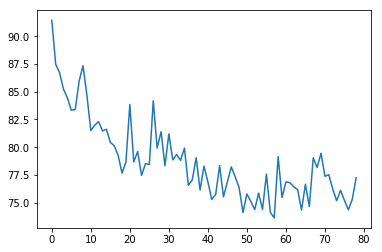

In [40]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
% matplotlib inline
plt.figure()
plt.plot(all_losses)

In [31]:
max_length = 100

# Sample from a category and starting letter
def sample(keywords_dict, start_letter='W'):
    with torch.no_grad():  # no need to track history in sampling
#         category_tensor = categoryTensor(category)
        _input = inputTensor(start_letter, keywords_dict)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(max_length):
            output, hidden = rnn(_input[0].to(device), hidden.to(device))
            topv, topi = output.topk(1)
            topi = topi[0][0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)

        return output_name
sample(keywords_dict)

UnboundLocalError: local variable 'hidden' referenced before assignment

torch.nn.modules.rnn.RNN

In [29]:
with torch.no_grad():  # no need to track history in sampling
#         category_tensor = categoryTensor(category)
        _input = inputTensor(start_letter, keywords_dict)
        hidden = rnn.initHidden()

        output_name = start_letter

        for i in range(25):
            output, hidden = rnn(_input[0].to(device), hidden.to(device))
            topv, topi = output.topk(1)
            topi = topi[0][0]
            letter = keywords_dict['all_letters'][topi]
            output_name += letter
            _input = inputTensor(letter, keywords_dict)

NameError: name 'start_letter' is not defined

In [62]:
import numpy as np

np.sum(np.exp(np.array(output)[0]))

1.0000001

In [8]:
x = torch.tensor([1, 2, 3, 4])

In [9]:
x.unsqueeze_(-1)

tensor([[1],
        [2],
        [3],
        [4]])

In [174]:
class RNN3(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.n_layers = n_layers
        self.rnn = nn.RNN(input_size, hidden_size, n_layers, dropout=0.1)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=2)

    def forward(self, input):
        hidden = self.initHidden(input.size(1))
        return_ = []
        for i in range(input.size(0)):
            _input = input[i:i+1]
            output, hidden = self.rnn(_input, hidden)
            output = self.fc(output)
            output = self.softmax(output)
            return_.append(output)
        return return_
    
    def prediction(self, input, hidden):
        output, hidden = self.rnn(input, hidden)
        output = self.fc(output)
        output = self.softmax(output)
        return output, hidden
    def initHidden(self, batch_size):
        return torch.zeros(self.n_layers, batch_size, self.hidden_size).cuda()

In [176]:
from  torch import autograd 

input_line_tensor, target_line_tensor = createTrainingExample(data[0:26], keywords_dict)
rnn_ = RNN3(keywords_dict['n_letters'], 512, keywords_dict['n_letters'], 3)
if torch.cuda.is_available:
    rnn_.cuda()
# _ = input_line_tensor.long()
output = rnn_(input_line_tensor.cuda())
# output = rnn_(input_line_tensor.cuda())
# # input_line_tensor[0:1]
rnn_.prediction(input_line_tensor[0:1].cuda(), rnn_.initHidden(1))

(tensor([[[-4.2523, -4.1594, -4.1699, -4.2205, -4.2009, -4.2164, -4.2171,
           -4.2176, -4.2197, -4.2371, -4.2394, -4.1524, -4.1625, -4.1826,
           -4.2385, -4.2265, -4.1625, -4.1945, -4.2177, -4.1837, -4.2111,
           -4.1731, -4.2336, -4.1715, -4.1978, -4.1579, -4.2368, -4.2543,
           -4.2361, -4.2385, -4.1179, -4.2428, -4.1598, -4.2166, -4.1801,
           -4.2521, -4.2979, -4.2284, -4.1959, -4.2158, -4.1834, -4.1235,
           -4.1715, -4.1693, -4.1514, -4.2164, -4.1780, -4.1881, -4.1893,
           -4.2664, -4.2511, -4.1677, -4.2127, -4.2389, -4.1562, -4.1671,
           -4.1913, -4.2419, -4.2399, -4.1979, -4.2247, -4.1891, -4.2262,
           -4.2075, -4.2412, -4.2447, -4.2329]]], device='cuda:0'),
 tensor([[[-2.3057e-02, -2.3564e-02, -4.2954e-02,  ...,  1.4749e-02,
            8.8703e-02, -7.4408e-02]],
 
         [[-5.7274e-02, -6.1016e-02,  9.3120e-03,  ..., -1.4885e-03,
           -4.8879e-02, -1.0134e-02]],
 
         [[ 6.3342e-02,  1.7465e-02, -3.2752e-

In [183]:
def running(keywords_dict):
    n_letters = keywords_dict['n_letters']
    rnn =  RNN3(n_letters, 512, n_letters, 3)
    rnn.to(device)    


    seq_length = keywords_dict['seq_length']
    optimizer = torch.optim.Adam(rnn.parameters(), lr=0.001)
#     n_iters = 10
    print_every = 5000
    plot_every = 500
    all_losses = []
    total_loss = 0 # Reset every plot_every iters

    start = time.time()
    criterion = nn.NLLLoss().to(device)
    
    _iter, p = 0, 0
    while p + seq_length +1 <= keywords_dict['data_size']:
        input_line_tensor, target_line_tensor = createTrainingExample(data[p:p+seq_length+1], keywords_dict)
#         print(input_line_tensor.size())
        target_line_tensor.unsqueeze_(-1)

        input_line_tensor = input_line_tensor.cuda()
        output = rnn(input_line_tensor)
#         print(output)
        loss = 0
        for i in range(input_line_tensor.size(0)):
            l = criterion(output[i][0], target_line_tensor[i].to(device))
#             print(l)
            if loss==0:
                loss = l
            else:
                loss += l
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        p += seq_length # move data pointer
        _iter += 1 # iteration counter

        total_loss += loss

        if _iter % plot_every == 0:
            print('%s (%d %d%%) %.4f' % (timeSince(start), _iter, _iter / (keywords_dict['data_size']/keywords_dict['seq_length']) * 100, loss))

        if _iter % plot_every == 0:
            all_losses.append(total_loss / plot_every)
            total_loss = 0
    return rnn, all_losses
n_letters = keywords_dict['n_letters']

# rnn = nn.RNN(input_size=n_letters, hidden_size=512, num_layers=3, nonlinearity='tanh')
# rnn.to(device)
rnn, all_losses = running( keywords_dict)

0m 40s (500 1%) 77.6373
1m 20s (1000 2%) 84.1484
2m 1s (1500 3%) 86.6846
2m 41s (2000 5%) 121.4769
3m 21s (2500 6%) 88.7474
4m 2s (3000 7%) 75.2751
4m 42s (3500 8%) 92.3100
5m 23s (4000 10%) 85.6432
6m 3s (4500 11%) 79.6013
6m 44s (5000 12%) 74.3576
7m 24s (5500 13%) 87.5127
8m 4s (6000 15%) 76.2123
8m 45s (6500 16%) 90.3462
9m 25s (7000 17%) 79.5136
10m 6s (7500 18%) 92.2264
10m 47s (8000 20%) 97.5097
11m 28s (8500 21%) 86.2393
12m 9s (9000 22%) 82.4376
12m 50s (9500 23%) 102.5323
13m 33s (10000 25%) 84.1528
14m 16s (10500 26%) 101.1602
14m 58s (11000 27%) 80.3856
15m 39s (11500 28%) 93.1155
16m 23s (12000 30%) 91.7584
17m 3s (12500 31%) 87.9460
17m 44s (13000 32%) 78.6555
18m 24s (13500 33%) 85.0535
19m 4s (14000 35%) 81.6005
19m 45s (14500 36%) 78.9428
20m 25s (15000 37%) 84.9486
21m 6s (15500 38%) 82.1121
21m 46s (16000 40%) 82.4816
22m 26s (16500 41%) 120.9892
23m 7s (17000 42%) 92.3614
23m 47s (17500 43%) 86.7239
24m 27s (18000 45%) 92.6668
25m 8s (18500 46%) 82.6646
25m 48s (190

In [192]:
max_length = 5

# Sample from a category and starting letter
# def sample(keywords_dict, start_letter='A'):
with torch.no_grad():  # no need to track history in sampling
#         category_tensor = categoryTensor(category)
    start_letter='C'
    _input = inputTensor(start_letter, keywords_dict)
#         _input.to(device)
    hidden = rnn.initHidden(1)
    output_name = start_letter

    for i in range(max_length):
        output, hidden = rnn.prediction(_input.to(device), hidden.to(device))
        topv, topi = output[0][0].topk(1)
        topi = topi[0]
        letter = keywords_dict['all_letters'][topi]
        output_name += letter
        _input = inputTensor(letter, keywords_dict)
        _input.to(device)
#     return output_name
# sample(keywords_dict)

In [189]:
        topv, topi = output[0][0].topk(1)
#         topi = topi[0]

In [190]:
keywords_dict['all_letters'][topi]

' '

In [191]:
output_name

'BOE\n\n '